# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
!pip install smdebug

You should consider upgrading via the '/Users/zenysisaccount/work/sageMaker/sagemaker/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!pip install --upgrade bokeh==2.4.3

     |████████████████████████████████| 18.5 MB 5.9 MB/s eta 0:00:01
You should consider upgrading via the '/Users/zenysisaccount/work/sageMaker/sagemaker/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import sagemaker
import boto3
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/zenysisaccount/Library/Application Support/sagemaker/config.yaml


## Dataset
The dataset utilized for this project is a curated segment of the ImageNet database, specifically filtered to include only dog images. It features 133 distinct classes, each representing a different dog breed. The collection provides a spectrum of dog breeds, and an understanding of the class distribution is essential for appreciating the dataset’s diversity and potential biases, which is particularly beneficial for those not previously acquainted with it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip > /dev/null 2>&1
!aws s3 sync dogImages s3://sagemaker-deep-learning-project/dogImages > /dev/null 2>&1

--2023-11-06 15:21:05--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.216.80, 52.219.221.24, 52.219.113.128, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.216.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  3.11MB/s    in 8m 50s  

2023-11-06 15:29:56 (2.04 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
# Define the range of hyperparameters for tuning
hyperparameter_ranges = {
    'learning-rate': ContinuousParameter(0.001, 0.1),  # Learning rate continuous range from 0.001 to 0.1
    'batch-size': IntegerParameter(16, 128)  # Batch size integer range from 16 to 128
}

# Define the objective metric name and type
objective_metric_name = 'validation accuracy'
objective_type = 'Maximize'

# Define the metric definitions to extract the appropriate metric from logs
metric_definitions = [{'Name': 'validation accuracy', 'Regex': 'Accuracy: ([0-9\\.]+)'}]

BUCKET = 'sagemaker-deep-learning-project'

In [8]:
role = sagemaker.get_execution_role()

estimator = PyTorch(entry_point='hpo.py',
                    role=role,
                    instance_count=1,
                    instance_type='ml.p3.2xlarge',
                    framework_version='1.8.0',
                    py_version='py3',
                    hyperparameters={
                        'epochs': 10,
                        'num-classes': 133,
                        's3-bucket': BUCKET,
                        's3-model-path': 'model'
                    })

tuner = HyperparameterTuner(estimator=estimator,
                            objective_metric_name=objective_metric_name,
                            objective_type=objective_type,
                            hyperparameter_ranges=hyperparameter_ranges,
                            metric_definitions=metric_definitions,
                            max_jobs=5,
                            max_parallel_jobs=1)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/zenysisaccount/Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/zenysisaccount/Library/Application Support/sagemaker/config.yaml


In [ ]:
DATA_PREFIX = 'dogImages'

data_channels = {
    "train": "s3://{}/{}/train/".format(BUCKET, DATA_PREFIX),
    "test": "s3://{}/{}/test/".format(BUCKET, DATA_PREFIX),
    "valid": "s3://{}/{}/valid/".format(BUCKET, DATA_PREFIX)
}

tuner.fit(inputs=data_channels)

In [14]:
# TODO: Get the best estimators and the best HPs
# Get the name of the hyperparameter tuning job
tuning_job_name = tuner.latest_tuning_job.job_name

# Get the best performing hyperparameter set
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hps = best_estimator.hyperparameters()
print(best_hps)

hyperparameters = {'batch-size': int(best_hps['batch-size']), 
                   'learning-rate': best_hps['learning-rate'],
                   'epochs': 10,
                    'num-classes': 133,
                    's3-bucket': BUCKET,
                    's3-model-path': 'model'
                  }
hyperparameters

{'batch-size': 86,
 'learning-rate': '0.002206587666624999',
 'epochs': 10,
 'num-classes': 133,
 's3-bucket': 'sagemaker-deep-learning-project',
 's3-model-path': 'model'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [16]:
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "50", "eval.save_interval": "5"}
)


Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [ ]:
estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    framework_version='1.8.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=debugger_config,
    profiler_config=profiler_config,
)

s3_input_train = sagemaker.inputs.TrainingInput(s3_data=data_channels['train'], content_type='application/x-image')
s3_input_valid = sagemaker.inputs.TrainingInput(s3_data=data_channels['valid'], content_type='application/x-image')
s3_input_test = sagemaker.inputs.TrainingInput(s3_data=data_channels['test'], content_type='application/x-image')

# Fit the model
estimator.fit({'train': s3_input_train, 'valid': s3_input_valid, 'test': s3_input_test})

In [52]:
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2023-11-05-14-26-08-198
Region: us-east-1


In [41]:
from smdebug.trials import create_trial
import matplotlib.pyplot as plt
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
import os
import IPython

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2023-11-06 18:51:50.951 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:34 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?


[2023-11-06 18:51:52.041 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:34 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-144230986696/pytorch-training-2023-11-06-13-54-59-702/debug-output
[2023-11-06 18:51:52.511 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:34 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-11-06 18:51:53.529 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:34 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', 'layer4.1.relu_input_0', 'l

In [42]:
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-144230986696/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-144230986696/pytorch-training-2023-11-06-13-54-59-702/profiler-output


Profiler data from system is available
[2023-11-06 18:51:59.719 pytorch-1-10-gpu-py-ml-g4dn-xlarge-53638dc8bb3d40f5ed7ac21aaf03:34 INFO metrics_reader_base.py:134] Getting 10 event files
selec

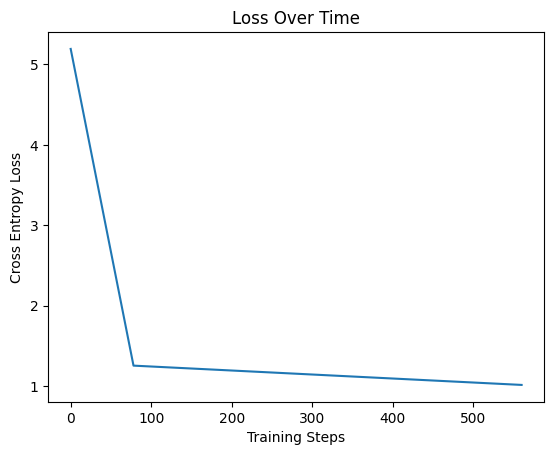

In [23]:
# Retrieve the values of the CrossEntropyLoss tensor
loss_values = trial.tensor('CrossEntropyLoss_output_0').values()

steps = sorted(loss_values.keys())
losses = [loss_values[step] for step in steps]  # No [0] index

plt.plot(steps, losses)
plt.title('Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.show()

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [25]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-144230986696/pytorch-training-2023-11-06-13-54-59-702/rule-output


In [26]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2023-11-06 17:05:45     389476 pytorch-training-2023-11-06-13-54-59-702/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-11-06 17:05:44     239596 pytorch-training-2023-11-06-13-54-59-702/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-11-06 17:05:40        191 pytorch-training-2023-11-06-13-54-59-702/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-11-06 17:05:40      15589 pytorch-training-2023-11-06-13-54-59-702/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-11-06 17:05:40       2084 pytorch-training-2023-11-06-13-54-59-702/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-11-06 17:05:40        129 pytorch-training-2023-11-06-13-54-59-702/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-11-06 17:05:40        961 pytorch-training-2023-11-06-13-54-59-702/rule-output/ProfilerReport/profiler-output/profiler-re

In [51]:
from IPython.display import HTML

# Set the path to the profiler report
profiler_report_path = "./ProfilerReport/profiler-output/profiler-report.html"

local_file = HTML(filename=profiler_report_path)
display(local_file)

## Model Deploying

In [43]:
# TODO: Deploy your model to an endpoint
from sagemaker.pytorch import PyTorchModel

# Create a PyTorchModel object
pytorch_model = PyTorchModel(
    model_data=estimator.model_data,  # This is the S3 location of your trained model
    role=role,                        # Your IAM role with the necessary permissions
    entry_point='inference.py',       # Your entry point file (inference script)
    framework_version='1.8.0',        # PyTorch framework version used
    py_version='py3',                 # Python version
)

In [44]:
# Deploy the model
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
)

INFO:sagemaker:Creating model with name: pytorch-inference-2023-11-06-18-54-51-096
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-11-06-18-54-51-881
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-11-06-18-54-51-881


-------!

In [55]:
import requests
request_dict={ "url": "https://cdn.britannica.com/49/161649-050-3F458ECF/Bernese-mountain-dog-grass.jpg" }

img_bytes = requests.get(request_dict['url']).content

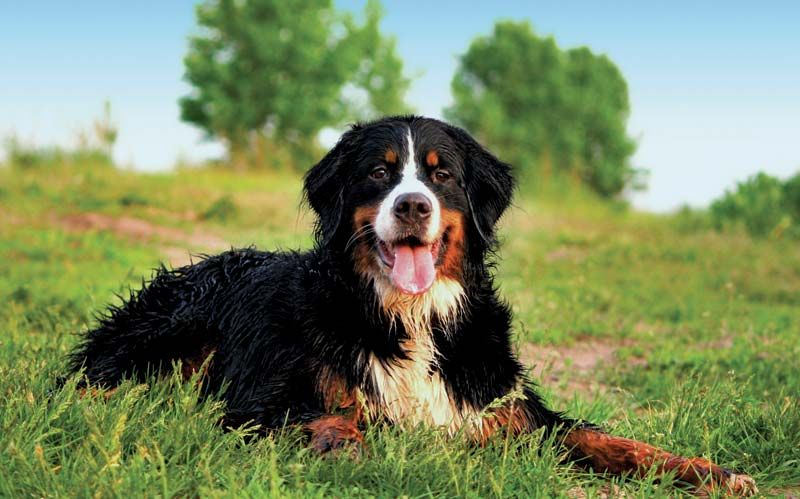

In [46]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [52]:
import boto3

# Create a SageMaker client
sagemaker = boto3.client('sagemaker')

# List endpoints and sort by creation time
response = sagemaker.list_endpoints(SortBy='CreationTime', SortOrder='Descending')

# Assume you want the most recently created endpoint, you can adjust the logic here as needed
latest_endpoint = response['Endpoints'][0]['EndpointName']

# Now you can use the latest endpoint name in the invoke_endpoint call
runtime = boto3.client('sagemaker-runtime')

response = runtime.invoke_endpoint(
    EndpointName=latest_endpoint,
    ContentType='application/x-image',
    Body=img_bytes  # the image bytes you obtained from the requests.get call
)

print(response)

{'ResponseMetadata': {'RequestId': '09aed1be-e51b-40aa-a4c2-da88c55362e8', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '09aed1be-e51b-40aa-a4c2-da88c55362e8', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Mon, 06 Nov 2023 19:06:15 GMT', 'content-type': 'application/json', 'content-length': '3254', 'connection': 'keep-alive'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7f5f8e7e57f0>}


In [53]:
import json

# Get the response body and read it
streaming_body = response['Body']
json_response_body = streaming_body.read()

# The response body is a byte string, so you'll need to decode it
decoded_response_body = json_response_body.decode('utf-8')

# The decoded response body is a JSON string, so you can parse it to get a Python object
prediction = json.loads(decoded_response_body)

print(prediction)

[[-14.367409706115723, -5.256139278411865, -9.15707015991211, -12.734663009643555, -8.390789985656738, -14.617938995361328, -9.91048526763916, -11.586962699890137, -6.76397705078125, -10.073419570922852, -8.36524486541748, -0.6332104802131653, -9.050278663635254, -7.661988735198975, -4.754453659057617, -8.722458839416504, -8.390300750732422, -4.615124225616455, -13.669710159301758, -12.671073913574219, -10.509272575378418, -12.130860328674316, 5.0755085945129395, -14.200041770935059, -5.160635471343994, -7.904695987701416, -11.3967866897583, -6.624794960021973, -1.3690067529678345, -13.6615629196167, -7.602124214172363, -10.531726837158203, -10.23701286315918, -11.362525939941406, -7.975805282592773, -8.763970375061035, -8.030843734741211, -13.774123191833496, -12.125836372375488, -14.764016151428223, -15.393117904663086, -12.483383178710938, -9.02830982208252, -12.328771591186523, -5.317493438720703, -2.3427841663360596, -12.315791130065918, -11.821271896362305, -11.2426118850708, -14

In [54]:
import numpy as np

# Convert the prediction to a numpy array
prediction_array = np.array(prediction)

# Find the index of the maximum value
predicted_class = np.argmax(prediction_array)

print(predicted_class)

22


In [34]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()